<a href="https://colab.research.google.com/github/Confidentrf/Cattura/blob/master/3_2_Transfer_Learning_With_TensorFlow_Hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Transfer Learning with TensorFlow Hub

Image Classification

This notebook is very similar to the example from Section 2 Transfer Learning witha pretrained ConvNet Except for the following:

Datasets: the Oxford Flowers 102 (instead of the tf_flowers dataset)
Base model: MobileNetv2 from TensorFlow Hub (instead of tf.keras.applications)

In [1]:
# Enable TensorFlow 2.0
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

# Verify TensorFlow version
print(tf.__version__)

# Create a constant tensor
hello = tf.constant('Hello, TensorFlow!')

# Use tf.print instead of session run
tf.print(hello)


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.17.0
Hello, TensorFlow!


In [2]:
#import tensorflow
import tensorflow as tf
tf.__version__

'2.17.0'

In [3]:
# Import TensorFlow dataset
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Install tfds-nightly so that we can download oxford_flowers102 version 2.1.0
!pip install tfds-nightly

import tensorflow_datasets as tfds

# Import Keras
from tensorflow import keras
"""from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam"""
# Import Tensorflow hub
import tensorflow_hub as hub

# Import Numpy
import numpy as np
import matplotlib.pyplot as plt


Data Pipeline

Load Flowers

In [4]:
# Load train and validation datasets
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='oxford_flowers102:2.1.1',
    split=['test', 'validation', 'train'], # train, validation, test split of 8:1:1
    with_info=True,
    as_supervised=True,
)

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [20]:
num_classes = metadata.features["label"].num_classes
num_train = len(list(raw_train))
num_validation = len(list(raw_validation))
num_test = len(list(raw_test))

print("Number of classes:", num_class)
print("Number of training samples:", num_train)
print("Number of validation samples:", num_validation)
print("Number of test samples:", num_test)


Number of classes: 102
Number of training samples: 6149
Number of validation samples: 1020
Number of test samples: 1020


In [21]:
# Inspect datasets before data processing
print(raw_train)
print(raw_validation)
print(raw_test)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [22]:
# Get labels / class names
class_names = np.array(metadata.features["label"].names)
class_names

array(['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells',
       'sweet pea', 'english marigold', 'tiger lily', 'moon orchid',
       'bird of paradise', 'monkshood', 'globe thistle', 'snapdragon',
       "colt's foot", 'king protea', 'spear thistle', 'yellow iris',
       'globe-flower', 'purple coneflower', 'peruvian lily',
       'balloon flower', 'giant white arum lily', 'fire lily',
       'pincushion flower', 'fritillary', 'red ginger', 'grape hyacinth',
       'corn poppy', 'prince of wales feathers', 'stemless gentian',
       'artichoke', 'sweet william', 'carnation', 'garden phlox',
       'love in the mist', 'mexican aster', 'alpine sea holly',
       'ruby-lipped cattleya', 'cape flower', 'great masterwort',
       'siam tulip', 'lenten rose', 'barbeton daisy', 'daffodil',
       'sword lily', 'poinsettia', 'bolero deep blue', 'wallflower',
       'marigold', 'buttercup', 'oxeye daisy', 'common dandelion',
       'petunia', 'wild pansy', 'primula', 'sunflower

Let's take a look a few of the flower images

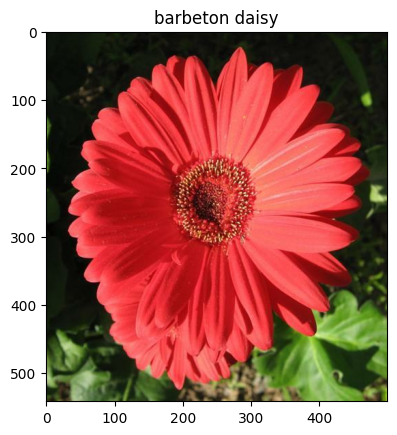

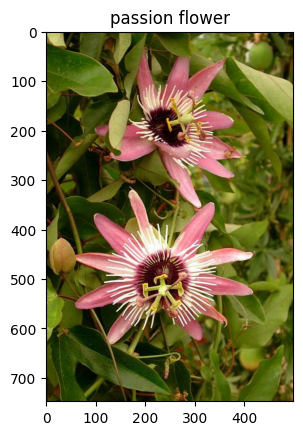

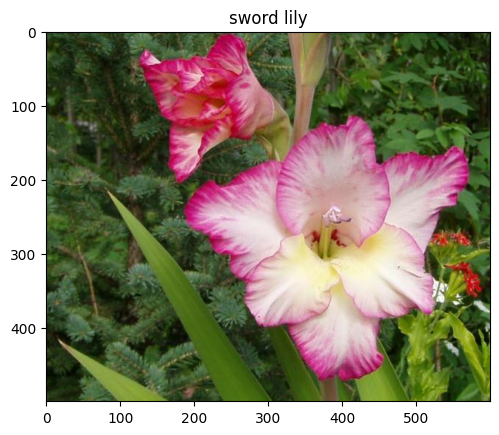

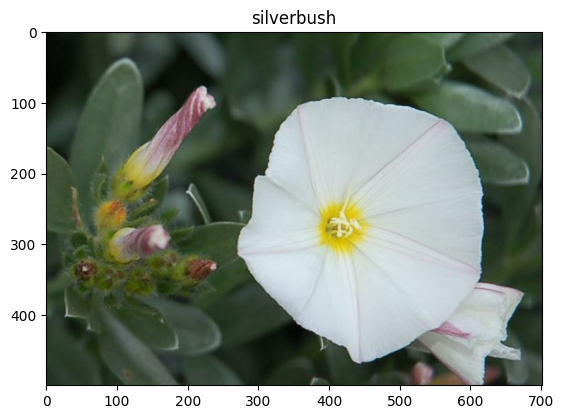

In [23]:
label_names = metadata.features["label"].int2str

for image, label in raw_train.take(4):
  plt.figure()
  plt.imshow(image)
  plt.title(label_names(label))

In [24]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = image/255.0
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [25]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [26]:
def augment_data(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_contrast(image, lower=0.0, upper=1.0)
  image = tf.stack(image, axis=0)
  imaag = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  return image, label

In [27]:
train = train.map(augment_data)

Shuffle and Batch Dataset

In [28]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()
validation_batches = validation.batch(BATCH_SIZE).repeat()
test_batches = test.batch(BATCH_SIZE)

In [14]:
# Inspect datasets after data processing
print(train_batches)
print(validation_batches)
print(test_batches)

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_RepeatDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [29]:
# Inspect a batch of data
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 224, 224, 3])

Training

Create the Model

In [43]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
IMG_SHAPE = (224, 224, 3)  # Example shape, modify as needed

feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=IMG_SHAPE, trainable=False)


In [45]:
# Example with a simpler layer
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = tf.keras.layers.Flatten()(inputs)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 102)                 │      15,353,958 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,353,958 (58.57 MB)

 Trainable params: 15,353,958 (58.57 MB)

 Non-trainable params: 0 (0.00 B)

Complile the Model  


In [48]:
model.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

Train Model

In [46]:
"""model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=IMG_SHAPE),  # Add an InputLayer
  hub.KerasLayer(handle=feature_extractor_layer.handle),  # Wrap the KerasLayer in a hub.KerasLayer
  tf.keras.layers.Dense(num_class, activation='softmax')
])

model.summary()"""

"model = tf.keras.Sequential([\n  tf.keras.layers.InputLayer(input_shape=IMG_SHAPE),  # Add an InputLayer\n  hub.KerasLayer(handle=feature_extractor_layer.handle),  # Wrap the KerasLayer in a hub.KerasLayer\n  tf.keras.layers.Dense(num_class, activation='softmax')\n])\n\nmodel.summary()"

In [49]:
#Set Traiing Prameters
NUM_EPOCHS = 10
STEPS_PER_EPOCH = num_train // BATCH_SIZE
VALIDATION_STEPS = num_validation // BATCH_SIZE

In [50]:
history = model.fit(train_batches,
                    epochs=NUM_EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=validation_batches,
                    validation_steps=VALIDATION_STEPS)

Epoch 1/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.0259 - loss: 180.3770 - val_accuracy: 0.0716 - val_loss: 63.7828
Epoch 2/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step - accuracy: 0.0817 - loss: 51.0721 - val_accuracy: 0.0739 - val_loss: 62.6415
Epoch 3/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.0896 - loss: 54.5776 - val_accuracy: 0.0789 - val_loss: 61.3450
Epoch 4/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.1073 - loss: 51.6472 - val_accuracy: 0.0921 - val_loss: 63.1723
Epoch 5/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 25s 131ms/step - accuracy: 0.1231 - loss: 48.3880 - val_accuracy: 0.1103 - val_loss: 60.8548
Epoch 6/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 29s 152ms/step - accuracy: 0.1370 - loss: 44.7627 - val_accuracy: 0.1083 - val_loss: 72.8156
Epoch 7/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 25s 131ms/step - accuracy: 0.1383 - loss: 51.3658 - val_accuracy: 0.1407 - val_loss: 60.8200
Epoch 8/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - accuracy: 0.1

In [96]:
def display_training_curves(history, validation, title, subplot=None):
    acc = history.history['accuracy']
    val_acc = validation.history['val_accuracy']
    loss = history.history['loss']
    val_loss = validation.history['val_loss']
    epochs_range = range(len(acc))

    if subplot:
        plt.subplot(subplot)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title(title)
    plt.legend(loc='upper left')

    if subplot:
        plt.subplot(subplot + 1)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title('Loss')
    plt.legend(loc='upper left')

    plt.show()


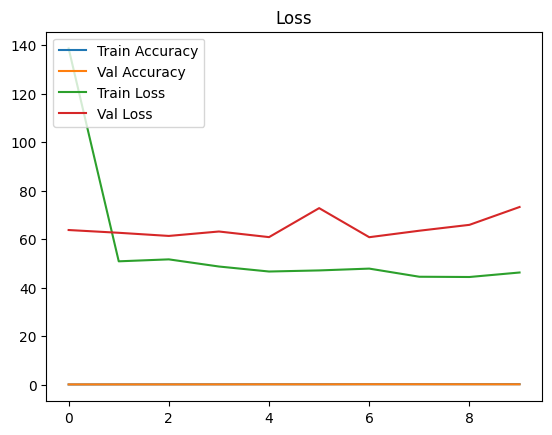

In [97]:
# Display training curves
display_training_curves(history, history, "Transfer Learning with TF Hub - CNN")

In [98]:
#evaluate the model on the test dataset
score = model.evaluate(test_batches, verbose=0)

#print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.12745098769664764


Baseline - Train from Scratch
Train Very simple CNN model and use the accuracy metrics as a baseline to compare with transfer learning results

Create Model

Visualize predictions

In [99]:
image_batch, label_batch = next(iter(test_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_class_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_class_ids]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


Then we visualize some of the images and compare weather the prdicted labels equal to the true labels.

Text(0.5, 0.98, 'Model Predictions')

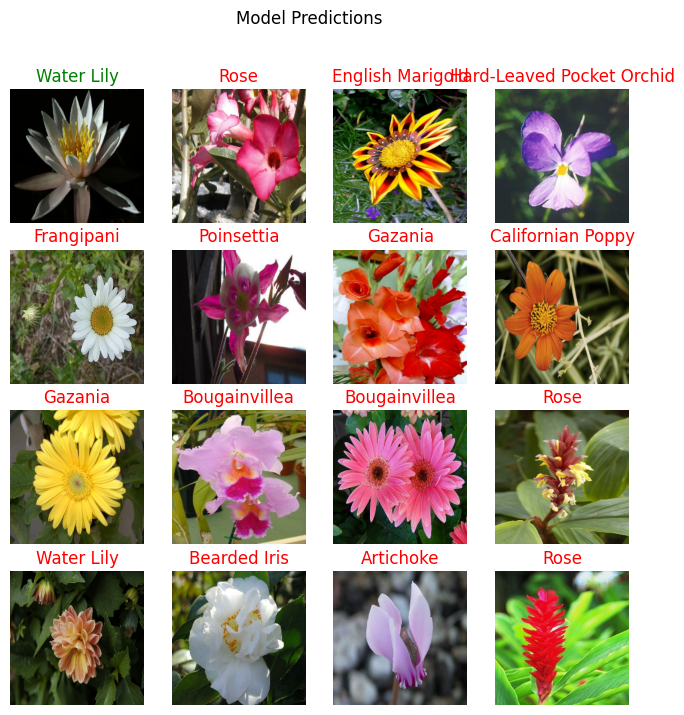

In [100]:
plt.figure(figsize=(8,8))

#Display 16 test images with predictions
for i in range(16):
  plt.subplot(4, 4, i + 1)
  #Display each image
  plt.imshow(image_batch[i])
   #Set title color:green if predicted label is correct
  title_color = "green" if predicted_class_ids[i] == label_batch[i] else "red"
  plt.title(predicted_class_names[i].title(), color=title_color)
  plt.axis('off')
plt.suptitle("Model Predictions")

Note the above has a low level of perdictiom as one image is green. the AI model needs to be further trained to better the predictions.
